# One-Dimensional linear Aquifer Storage and Recovery.

In this notebook, we will learn how to:
1. Setup a MODFLOW 6 model for one-dimensional flow and transport.
2. Simulate injection of freshwater in a saltwater aquifer (no buoyancy)
3. Visualize the output and assess numerical dispersion
4. Simulate both injection and recovery of freshwater in a saltwater aquifer
5. Compute the recovery efficiency

In [120]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp

## Description of the flow problem
Consider one-dimensional flow in a semi-infinite confined aquifer. The aquifer extends from $x=0$ to $x=L$ in the $x$ direction, where $L$ is chosen far enough away not to effect the flow solution.  Water is injected at the left side at a rate $U$ such that the average velocity in the aquifer is 1 m/d. The head is fixed on the right side to $h_R$. Flow is considered to be at steady state instantaneously. The model consists of 5 layers of the same thickness and hydraulic conductivity. Injection is equally distributed across the layers.

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$ and lasts for $t_\text{in}$ days.

### Parameters

In [121]:
# domain size and boundary conditions
L = 80 # length of domain, m
hR = 0 # head at right side of domain

# aquifer parameters
k = 20 # hydraulic conductivity, m/d
H = 20 # aquifer thickness, m
npor = 0.25 # porosity, -

# flow
vavg = 1 # average velocity, m/d
U = vavg * npor * H # computed total inflow, m^2/d

# transport
alphaL = 0.1 # longitudinal dispersivity in horizontal direction, m
alphaT = alphaL / 10 # transverse dispersivity is 10 times smaller than longitudinal, m
diffusion_coef = 0 # diffusion is not modeled

# concentration
cs = 1 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
nlay = 5 # number of layers
nrow = 1 # number of rows
ncol = round(L / delr) # number of columns, integer
z = np.linspace(0, -H, nlay + 1) # top and bottom(s) of layers
xg = np.cumsum(delr * np.ones(ncol)) - delr / 2 # x-values centers of grid cells, m
zc = 0.5 * (z[:-1] + z[1:]) # z-values centers of grid cells, m

# time and time discretization
tin = 50 # injection time, d
delt = 0.5 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer

# model name and workspace
modelname = 'model1d' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used (where MODFLOW will store all the files)

In [122]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='./bin/mf6', # path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=1, # number of stress periods 
                          perioddata=[[tin, nstepin, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)

In [123]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=k, # horizontal k value
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = []
for ilay in range(nlay):
    wellin.append([(ilay, 0, 0), U / nlay, cf]) # [(layer, row, col), U, concentration] during injection
wel_spd = {0: wellin} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd0 = []
for ilay in range(nlay):
    chd0.append([(ilay, 0, ncol - 1), hR, cs]) # [(layer, row, col), head, concentration]
chd_spd  = {0: chd0} # stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)

In [124]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, # add to gwt model
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=npor, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")] # list of (pname, 'AUX', 'CONCENTRATION')
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="upstream", # use the upstream method
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL, # longitudinal dispersivity
                           ath1=alphaT, # transverse dispersivity
                           diffc=diffusion_coef, # diffusion coefficient
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

Define the interaction between the groundwater flow model and the transport model and add it to the simulation.

In [125]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name, # name of groundwater flow model 
                     exgmnameb=gwt.name, # name of transport model
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model

In [126]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


## Read head data and make plot
The head is steady (storage is not simulated), so it should be the same for all times. 
Injection is the same in all layers, so the head is also the same in all layers.

In [127]:
hds = gwf.output.head() # get handle to binary head file
head = hds.get_alldata().squeeze() # get all the head data from the file
times = np.array(hds.get_times()) # get times and make it an array
print(f'min, max head in model: {head.min():.2f}, {head[0].max():.2f} m')
print(f'shape of head array (ntimes, nlay, ncol): {head.shape}')

min, max head in model: 0.00, 0.99 m
shape of head array (ntimes, nlay, ncol): (100, 5, 400)


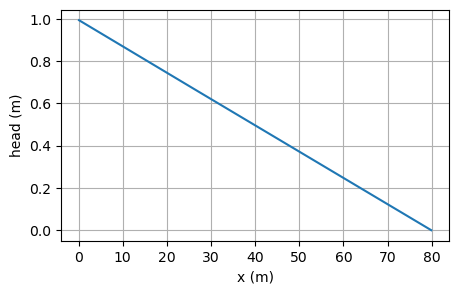

In [128]:
plt.plot(xg, head[0, 0])
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.grid()

## Read concentration data and make plot

In [129]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

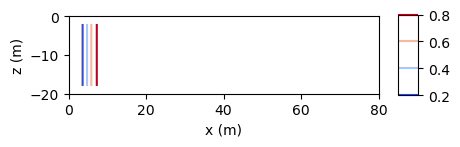

In [130]:
plt.subplot(111, xlim=(0, 80), ylim=(-20, 0), xlabel='x (m)', ylabel='z (m)', aspect=1)
cset = plt.contour(xg, zc, c[10], np.arange(0.2, 1, 0.2), cmap='coolwarm')
plt.colorbar(cset, shrink=0.35, aspect=4);

In [131]:
from ipywidgets import interact

def contour(t=delt):
    tstep = round(t / delt) - 1
    plt.subplot(111, xlim=(0, 80), ylim=(-20, 0), xlabel='x (m)', ylabel='z (m)', aspect=1)
    cset = plt.contour(xg, zc, c[tstep], np.arange(0.2, 1, 0.2), cmap='coolwarm')
    plt.colorbar(cset, shrink=0.35, aspect=4)

interact(contour, t=(delt, tin, delt));

interactive(children=(FloatSlider(value=0.5, description='t', max=50.0, min=0.5, step=0.5), Output()), _dom_cl…

For this example, the concentration is the same in all layers, so we can simply plot the concentration vs. x. Below, the concentration is plotted vs. $x$ at 10 day intervals.

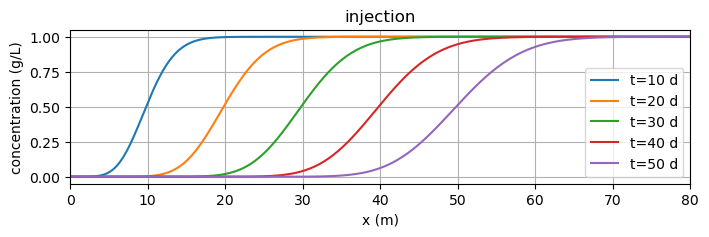

In [132]:
# plot concentration vs. x for three different times   
plt.figure(figsize=(8, 2))
for t in np.arange(10, 51, 10):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c[itime, 0], label=f't={times[itime]:.0f} d')
plt.title('injection')
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 80)
plt.legend()
plt.grid()

### Mass balance
The mass balance is computed by taking the difference between the total mass in the system at the end of the simulation and at the beginning of the simulation and comparing that to the total inflow minus the total outflow of mass.

In [133]:
mass_end = np.sum(c[-1, 0] * delr * npor * H)
mass_begin = np.sum(cs * L * npor * H)
print(f'total change of mass: {mass_end - mass_begin:.2f} kg')

total change of mass: -249.87 kg


In [134]:
mass_inflow = 0
mass_outflow = U * cs * tin
print(f'total inflow of mass: {mass_inflow - mass_outflow:.2f} kg')

total inflow of mass: -250.00 kg


### Compare to exact solution
The exact solution for the stated problem is (Van Genuchten and Alves, 1982):
\begin{equation}
c(x, t) = c_s + (c_f-c_s)\left[\frac{1}{2}\text{erfc}\left(\frac{x-vt}{2\sqrt{Dt}}\right) + 
\sqrt{\frac{v^2t}{\pi D}} \exp\left(\frac{-(x-vt)^2}{4Dt}\right) -
\frac{1}{2}\left(1 + \frac{vx}{D} + \frac{v^2t}{D}\right)\exp\left(\frac{vx}{D}\right)
\text{erfc}\left(\frac{x+vt}{2\sqrt{Dt}}\right)\right]
\end{equation}
where $D=\alpha_Lv$ is the dispersion coefficient, $v$ is the average velocity, and $\text{erfc}$ is the complimentary error function. 

In [135]:
from scipy.special import erfc

def c_exact(x, t, v, D, c0):
    rv = 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t))) + \
         np.sqrt(v ** 2 * t / (np.pi * D)) * np.exp(-(x - v * t) ** 2 / (4 * D * t)) - \
         0.5 * (1 + v * x / D + v ** 2 * t / D) * np.exp(v * x / D) * \
         erfc((x + v * t) / (2 * np.sqrt(D * t)))
    rv = np.nan_to_num(rv)
    rv = c0 - c0 * rv
    return rv

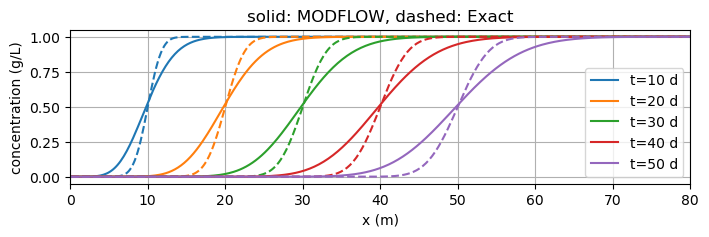

In [136]:
plt.figure(figsize=(8, 2))
for i, t in enumerate(np.arange(10, 51, 10)):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c[itime, 0], 'C' + str(i), label=f't={times[itime]:.0f} d')
    cex = c_exact(xg, t, vavg, alphaL, cs)
    plt.plot(xg, cex, 'C' + str(i), ls='--')
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 80)
plt.legend()
plt.title('solid: MODFLOW, dashed: Exact')
plt.grid()

### Exercise 1 Reduce numerical dispersion

Let's try to reduce numerical dispersion. There are three easy options to try to reduce numerical dispersion:
1. Use a more accurate solution approach for the advection part of the transport equation.
2. Use smaller cells.
3. Use smaller time steps.
   
We now specify the upstream scheme when solving the advection part of the transport equation in the `fp.mf6.ModflowGwtadv` class. A more accurate scheme is the `TVD` scheme. The cell size is already pretty small, but the time step can definitely be reduced. Use the Exercise1 notebook to determine accurate options that give an acceptable level of numerical dispersion. 

## Recovery phase
After injection, the water is recovered again by pumping the water out. The extraction rate is chosen the same as the injection rate. 
The model now has two stress periods: injection during the first stress period and extraction during the second stress period. 

In [137]:
# time and time discretization
tin = 50 # injection time, d
delt = 0.5 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer
tout = 50 # extraction time, d
delt = 0.5 # time step, d
nstepout = round(tout / delt) # computed number of steps during extraction, integer

The time discretization of the simulation is modified to reflect two stress periods

In [138]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='./bin/mf6', # path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1], # period length, number of steps, timestep multiplier
                                      [tout, nstepout, 1]], 
                         )

The only modification to the groundwater flow model is in the well package, where the injection and extraction rates are specified for the two stress periods.

In [139]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=k, # horizontal k value
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = []
for ilay in range(nlay):
    wellin.append([(ilay, 0, 0), U / nlay, cf]) # [(layer, row, col), U, concentration] during injection
wellout = []
for ilay in range(nlay):
    wellout.append([(ilay, 0, 0), -U / nlay, cf]) # [(layer, row, col), U, concentration] during injection
wel_spd = {0: wellin, 1:wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd0 = []
for ilay in range(nlay):
    chd0.append([(ilay, 0, ncol - 1), hR, cs]) # [(layer, row, col), head, concentration]
chd_spd  = {0: chd0} # stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

No other changes need to be made to the model

In [140]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, # add to gwt model
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=npor, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")] # list of (pname, 'AUX', 'CONCENTRATION')
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="upstream", # use the upstream method
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL, # longitudinal dispersivity
                           ath1=alphaT, # transverse dispersivity
                           diffc=diffusion_coef, # diffusion coefficient
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

In [141]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name, # name of groundwater flow model 
                     exgmnameb=gwt.name, # name of transport model
                     filename=f"{modelname}.gwfgwt",
                    );

In [142]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


In [143]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

In [144]:
from ipywidgets import interact

def contour(t=delt):
    tstep = round(t / delt) - 1
    plt.subplot(111, xlim=(0, 80), ylim=(-20, 0), xlabel='x (m)', ylabel='z (m)', aspect=1)
    cs = plt.contour(xg, zc, c[tstep], np.arange(0.2, 1, 0.2), cmap='coolwarm')
    plt.colorbar(cs, shrink=0.35, aspect=4)

interact(contour, t=(delt, tin + tout, delt));

interactive(children=(FloatSlider(value=0.5, description='t', min=0.5, step=0.5), Output()), _dom_classes=('wi…

## Recovery efficiency
Determine the first time when the concentration of the extracted water exceeds $c_\text{limit}=0.2$ kg/m$^3$ (g/L). 

In [145]:
climit = 0.2 # limit concentration, kg/m^3 (g/L)
for itime in range(nstepin, nstepin + nstepout):
    if c[itime, 0, 0] > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0, 0]:.2f} g/L')

first time when c exceeds climit: 92.5 d when concentration is 0.21 g/L


The recovery efficiency RE is defined as the volume of extacted water with a concentration below $c_\text{limit}$ divided by the volume of injected water:
\begin{equation}
\text{RE} = \frac{V_\text{extracted}}{V_\text{injected}}
\end{equation}

In [146]:
Vextracted = (times[itime - 1] - tin) * U # at itime c was above limit
Vinjected = tin * U
RE = Vextracted / Vinjected
print(f'recovery efficiency = {RE * 100:.1f} %')

recovery efficiency = 84.0 %


### Exercise 2
Investigate the effect on the recovery efficiency of changing the following parameters:
* Change the 'upstream' method to the 'TVD' method is the solution of the advection part and keep it to 'TVD' for the remainder of this exercise. How did the recovery efficiency change?
*  What happens to the recovery efficiency when the dispersivity is increased from $\alpha_L=0.1$ m to $\alpha_L=0.5$ m?
* Set the dispersivity back to $\alpha_L=0.1$ m. Compute the recovery efficiency for an injection period of 20 days. Did the recovery efficiency increase or decrease?
* Compute the recovery efficiency for an injection period of 100 days. Did the recovery efficiency increase or decrease? Intuition says that the recovery efficiency should increase. If that didn't happen, what other change do you have to make to the model?